In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
import dslabs_functions as dslab


In [2]:
df = pd.read_csv("../../../data/class_credit_score_outliers_removed.csv", index_col="ID")
print(df.shape)

(42864, 37)


In [3]:
def calculate_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    return accuracy, precision, recall, auc, f1

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, ComplementNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier

import dslabs_functions as dslabs
import seaborn as sns

In [5]:
def generate_eval_chart(df, scaler):
    target = "Credit_Score"
    X = df.drop(target, axis=1)
    y = df[target]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)
    print(f"Train#={len(X_train)} Test#={len(X_test)}")
    print(f"Labels={pd.unique(y_train)}")
    print(X_train.shape, y_train.shape)

    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    clf = KNeighborsClassifier()
    clf.fit(X_train_scaled, y_train)
    y_train_pred = clf.predict(X_train_scaled)
    y_test_pred = clf.predict(X_test_scaled)

    metrics_train = calculate_metrics(y_train, y_train_pred)
    metrics_test = calculate_metrics(y_test, y_test_pred)

    metrics_df = pd.DataFrame({
        'Metric': ['Accuracy', 'Precision', 'Recall', 'AUC', 'F1-Score'],
        'Training': metrics_train,
        'Test': metrics_test
    })
    metrics_melted = pd.melt(metrics_df, id_vars='Metric', var_name='Set', value_name='Score')

    fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(16, 6))
    sns.barplot(ax=axs[0], x='Metric', y='Score', hue='Set', data=metrics_melted)
    axs[0].bar_label(axs[0].containers[0], fmt="%.2f")
    axs[0].bar_label(axs[0].containers[1], fmt="%.2f")

    cm = confusion_matrix(y_test, y_test_pred)
    sns.heatmap(cm, ax=axs[1], annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['Actual Negative', 'Actual Positive'])
    return fig, axs

Train#=34291 Test#=8573
Labels=[1. 0.]
(34291, 36) (34291,)


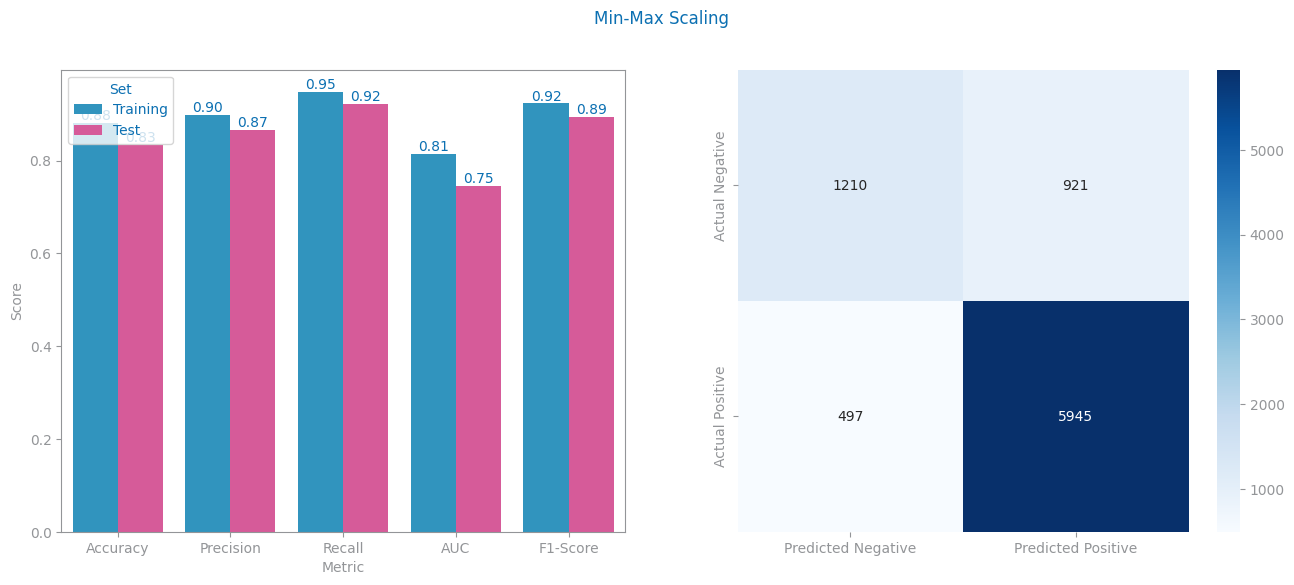

In [6]:
fig, axs = generate_eval_chart(df, scaler=MinMaxScaler(feature_range=(0,1), copy=True))
fig.suptitle("Min-Max Scaling")
plt.savefig(f"images/service_scaling_min_max.png")

Train#=34291 Test#=8573
Labels=[1. 0.]
(34291, 36) (34291,)


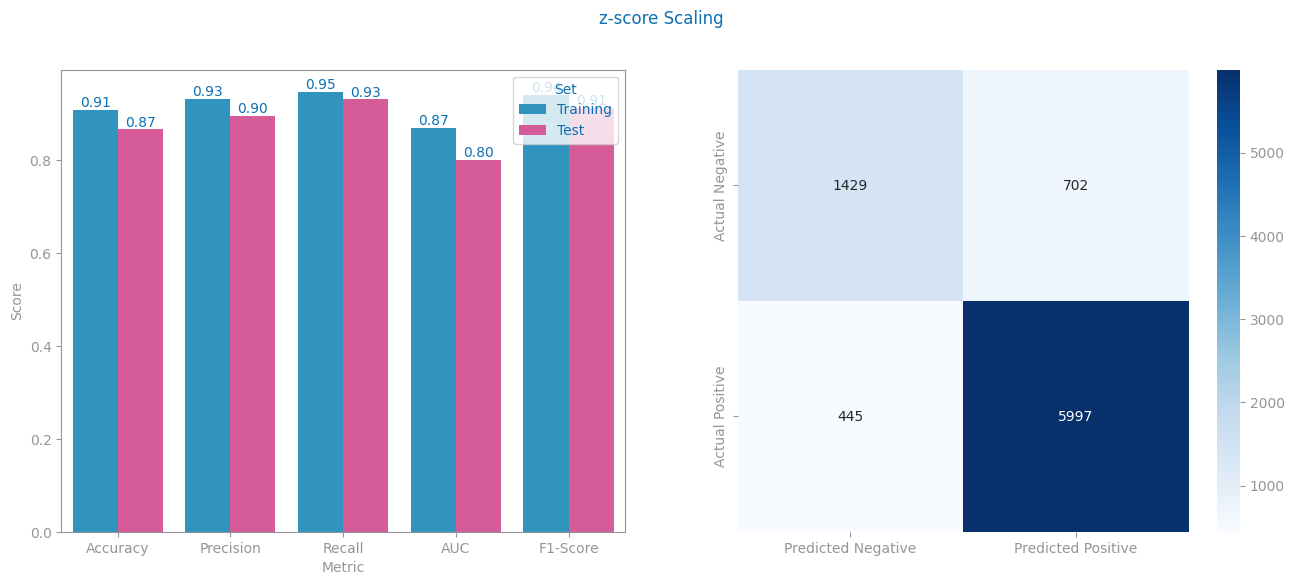

In [7]:
fig, axs = generate_eval_chart(df, scaler=StandardScaler(with_mean=True, with_std=True, copy=True))
fig.suptitle("z-score Scaling")
plt.savefig(f"images/service_scaling_z_score.png")

In [8]:
scaler = StandardScaler(with_mean=True, with_std=True, copy=True)
target = "Credit_Score"
X = df.drop(target, axis=1)
X_scaled = scaler.fit_transform(X)
df_scaled = pd.DataFrame(X_scaled, columns=X.columns, index=df.index)
df_scaled[target] = df[target]
df_scaled.to_csv("../../../data/class_credit_score_scaled.csv")